# Stock Analysis Utilizing Google Search Analytics
BAIS 6040: Data Programming in Python <br>

Group 01 : Andrew Turvey, Arielle Swift, Connor Moore, Dan Knobloch,  Ken Cupples, Shawn Sonnack <br>

28 July 2021 <br>

## Problem and Goal Statement:

The recent rise of retail investors and day traders,
as seen in news stories pertaining to GameStop and AMC,
coupled with the increase in internet usage for research,
and general information sharing purposes over the last 20
years poses an interesting question as to how stock price
and search engine hits (such as Google searches) are tied
together. More specifically our team analyzed how a desired
company’s closing stock price can be affected by “Google
Trends” search interest data to see if there is a strong
enough correlation to build a model that would accurately
predict a price increase for a given day and therefore
could generate a “buy signal” for traders.
	
Factors of importance needed to develop an acceptable model
will include: previous day’s share price, volume of shares
trade, and Google Trends search history score, which is a
number between 0-100 that is base lined  off of the highest
search interest day in a given time period. Data can
be pulled direct from most finance sites and the Google
Trend website. We then added a few manually calculated
relationship fields, such as whether or not the price or
trend increases the previous day to enhance our models.
Our model will be built and trained primarily on data
from Q2 in calendar year 2021 (April 01 – June 30)
and will be tested on July 2021 data. The model's performance
will be easily analyzed by comparing the predicted values
to the actual values.

## Import

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random as rnd
from datetime import date
from statistics import mean
from datetime import timedelta
from pytrends.request import TrendReq
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split    # For generating test/train
from sklearn.linear_model import LinearRegression   # Logistic regression

%matplotlib inline

## Global Variables and Initialization

In [2]:
dataDir = r"./Data Files/"  #Directory of all data
today = date.today()  # Today's date
rnd.seed(1024)

## Global Functions

In [3]:
# Function gets stock data and trend data if needed
def getData(stockName):
    if os.path.exists(f"{dataDir}{stockName}_{today}_year.csv"):
        # Get stored data
        storedData = pd.read_csv(f"{dataDir}{stockName}_{today}_year.csv")
        # Set date as index
        storedData.set_index("Date", inplace = True)
        return storedData
    else:
        # Get new data
        # Connect to Google API
        pytrends = TrendReq(hl='en-US', tz=360)
        # Set Keyword
        kw_list = [stockName]
        # Google API only shows last 90 days so need to itirate
        # Set start of interval
        date90Front = date.today()
        # Initiate dataframe
        trendData = pd.DataFrame()
        for _ in range(4):
            # Set start end of interval
            date90Back = date90Front - timedelta(days = 90)
            # Build Payload of 90 days
            pytrends.build_payload(kw_list,
                                   timeframe = f'{date90Back} {date90Front}',
                                   geo='')
            trend90 = pytrends.interest_over_time()
            trendData = pd.concat([trend90, trendData])
            date90Front = date90Back
        # Get Stock Data
        stockData = yf.download(stockName,
                                 start = date.today() - timedelta(days = 360),
                                 end = date.today(), interval = "1d")
        # Combine Data
        newData = stockData.join(trendData)
        # Set date as index
        newData.index.name = "Date"
        # Rename search interest
        newData.rename(columns = {stockName: "Search Interest"},inplace = True)
        # Add difference
        newData["Price Difference"] = newData["Close"] - newData["Open"]
        # Add truth value that determines if we want to buy or not that day
        newData['Buy'] = np.where(newData['Price Difference'] > 0, 1, 0)
        # Delete isPartial
        del newData['isPartial']
        # Remove NaN
        newData.dropna(inplace = True)
        # Export to data folder
        newData.to_csv(f"{dataDir}{stockName}_{today}_year.csv")
        return newData

# Function prints metrics of regression model
def printMetricsRegression(test, predictionsResult):
    print(f"Score: {explained_variance_score(test, predictionsResult):.2f}")
    print(f"MAE: {mean_absolute_error(test, predictionsResult):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(test, predictionsResult)):.2f}")
    print(f"r2: {r2_score(test, predictionsResult):.2f}")

## Analytics Model: Linear Regression on GME

In [4]:
# Gets Data for GME over last year
stockSearchDf_GME = getData("GME")

stockSearchDf_GME.head(5)

,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy
Date,,,,,,,,,
2020-08-03,4.03,4.25,4.00,4.15,4.15,2517600,15.0,0.12,1
2020-08-04,4.13,4.74,4.13,4.43,4.43,10361400,19.0,0.30,1
2020-08-05,4.50,4.76,4.25,4.63,4.63,4919300,21.0,0.13,1
2020-08-06,4.60,4.66,4.38,4.43,4.43,1901200,25.0,-0.17,0
2020-08-07,4.39,4.40,4.06,4.16,4.16,3341100,28.0,-0.23,0


In [5]:
featureColumns_GME = ['Search Interest', 'Open']
targetColumn_GME = 'Close'

X_GME = stockSearchDf_GME[featureColumns_GME]
y_GME = stockSearchDf_GME[targetColumn_GME]

X_train_GME, X_test_GME, y_train_GME, y_test_GME = train_test_split(X_GME, y_GME, test_size=0.08, shuffle=False)

#### Create the regression

In [6]:
lr = LinearRegression()
lr

LinearRegression()

#### Fit Linear Model

In [7]:
lr.fit(X_train_GME, y_train_GME)

LinearRegression()

#### Our Confidence in our model is high

In [8]:
lr.score(X_train_GME, y_train_GME)

0.9717565674479053

In [9]:
lr.score(X_test_GME, y_test_GME)

0.6111811944445478

lr.score(X_test_GME, y_test_GME)

#### Print the prediction believed accuracy using the model

In [10]:
predictions_GME = lr.predict(X_test_GME)
printMetricsRegression(y_test_GME, predictions_GME)

Score: 0.75
MAE: 6.87
RMSE: 8.97
r2: 0.61


#### Test model using last month data

In [11]:
lastMonthColumns_GME = ["Search Interest","Open","Close"]
lastMonthDf_GME = stockSearchDf_GME[lastMonthColumns_GME].loc[X_test_GME.index]
lastMonthDf_GME["Predicted Close"] = predictions_GME
lastMonthDf_GME.head(5)

,Search Interest,Open,Close,Predicted Close
Date,,,,
2021-06-28,35.0,211.250000,213.250000,204.469395
2021-06-29,32.0,213.589996,210.880005,206.994787
2021-06-30,29.0,209.690002,214.139999,203.499705
2021-07-01,29.0,213.399994,204.360001,207.079183
2021-07-02,28.0,204.800003,202.830002,198.870969


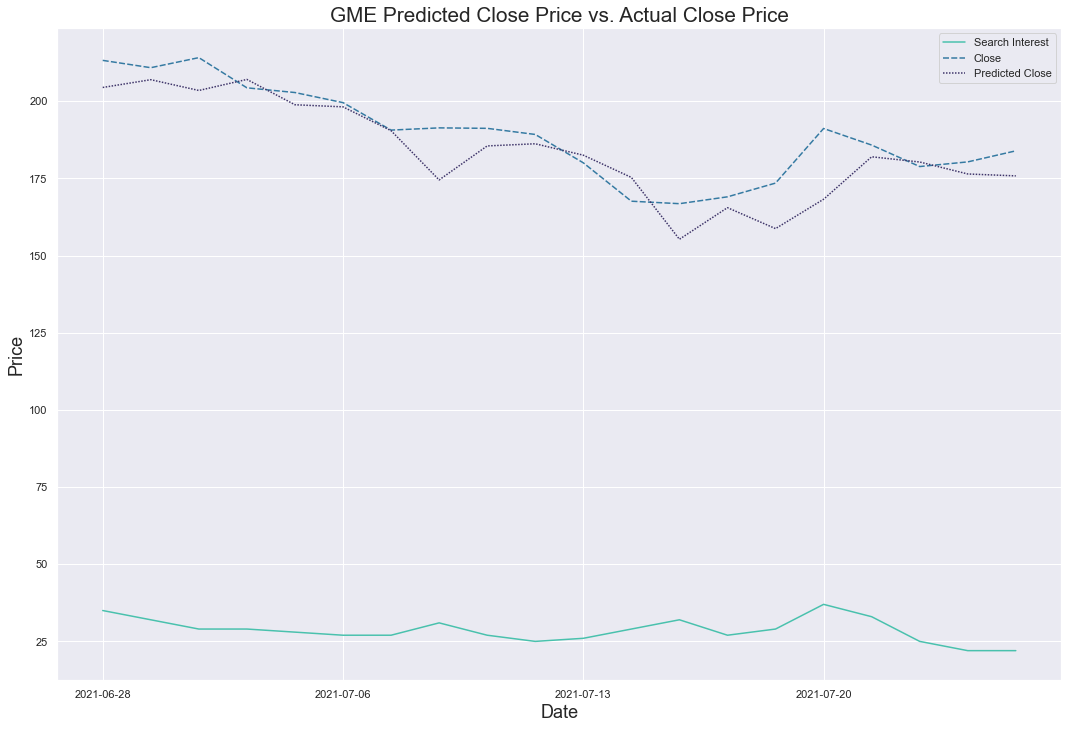

In [12]:
sns.set_theme(style = "darkgrid")
palette = sns.color_palette("mako_r", 3)
fig_GME, ax = plt.subplots(figsize = (18,12))
sns.lineplot(data=lastMonthDf_GME[["Search Interest","Close","Predicted Close"]],
                   ax = ax, palette = palette)

# Add title and axis labels
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.title("GME Predicted Close Price vs. Actual Close Price",
          fontsize = 'xx-large')
ax.xaxis.set_major_locator(mp.ticker.MultipleLocator(5))

# Add legend
plt.legend()

# Display plot
plt.show() 

## Analytics Model: Linear Regression on AMC

In [13]:
# Gets Data for AMC over last year
stockSearchDf_AMC = getData("AMC")

In [14]:
# Create offset of data

stockSearchDf_AMC['Previous Open'] = stockSearchDf_AMC['Open'].shift(1)
stockSearchDf_AMC['Previous High'] = stockSearchDf_AMC['High'].shift(1)
stockSearchDf_AMC['Previous Low'] = stockSearchDf_AMC['Low'].shift(1)
stockSearchDf_AMC['Previous Close'] = stockSearchDf_AMC['Close'].shift(1)
stockSearchDf_AMC['Previous Adj Close'] = stockSearchDf_AMC['Adj Close'].shift(1)
stockSearchDf_AMC['Previous Volume'] = stockSearchDf_AMC['Volume'].shift(1)
stockSearchDf_AMC['Previous Search Interest'] = stockSearchDf_AMC['Search Interest'].shift(1)
stockSearchDf_AMC.dropna(inplace=True)

In [15]:
columns_AMC = ["Previous Open", "Previous High", "Previous Low", "Previous Close", "Previous Volume", "Previous Search Interest", "Close"]
stockSearchDf_AMC = stockSearchDf_AMC[columns_AMC]

stockSearchDf_AMC.head(5)

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Close
Date,,,,,,,
2020-08-04,4.05,4.20,3.86,4.11,4047100.0,32.0,4.10
2020-08-05,4.07,4.24,4.06,4.10,3267800.0,32.0,4.15
2020-08-06,4.08,4.17,4.07,4.15,1691500.0,34.0,4.14
2020-08-07,4.11,4.24,3.99,4.14,3742600.0,34.0,4.75
2020-08-10,4.14,5.26,4.09,4.75,24917400.0,36.0,4.47


In [16]:
features_AMC = list(stockSearchDf_AMC.columns)
features_AMC.remove("Close")
target_AMC = "Close"

X_AMC = stockSearchDf_AMC[features_AMC]
y_AMC = stockSearchDf_AMC[target_AMC]

In [17]:
X_train_AMC, X_test_AMC, y_train_AMC, y_test_AMC = train_test_split(X_AMC, y_AMC, test_size=0.08, shuffle=False)

#### Create the regression

In [18]:
lr_AMC = LinearRegression()
lr_AMC

LinearRegression()

#### Fit Linear Model

In [19]:
lr_AMC.fit(X_train_AMC, y_train_AMC)

LinearRegression()

#### Our Confidence in our model is high

In [20]:
lr_AMC.score(X_train_AMC, y_train_AMC)

0.9582996027322584

In [21]:
lr_AMC.score(X_test_AMC, y_test_AMC)

0.7556955305442352

#### Print the prediction believed accuracy using the model

In [22]:
predictions_AMC = lr_AMC.predict(X_test_AMC)
printMetricsRegression(y_test_AMC, predictions_AMC)

Score: 0.78
MAE: 3.18
RMSE: 3.87
r2: 0.76


#### Test model using LastMonth data

In [23]:
lastMonthColumns_AMC = ["Previous Search Interest", "Close"]
lastMonthDf_AMC = stockSearchDf_AMC[lastMonthColumns_AMC].loc[X_test_AMC.index]
lastMonthDf_AMC["Predicted Close"] = predictions_AMC
lastMonthDf_AMC.rename(columns = {"Close": "Actual Close"},inplace = True)
lastMonthDf_AMC.head(5)


,Previous Search Interest,Actual Close,Predicted Close
Date,,,
2021-06-28,25.0,58.110001,55.411634
2021-06-29,25.0,56.430000,58.478051
2021-06-30,23.0,56.680000,58.205587
2021-07-01,26.0,54.220001,57.644275
2021-07-02,21.0,51.959999,55.122014


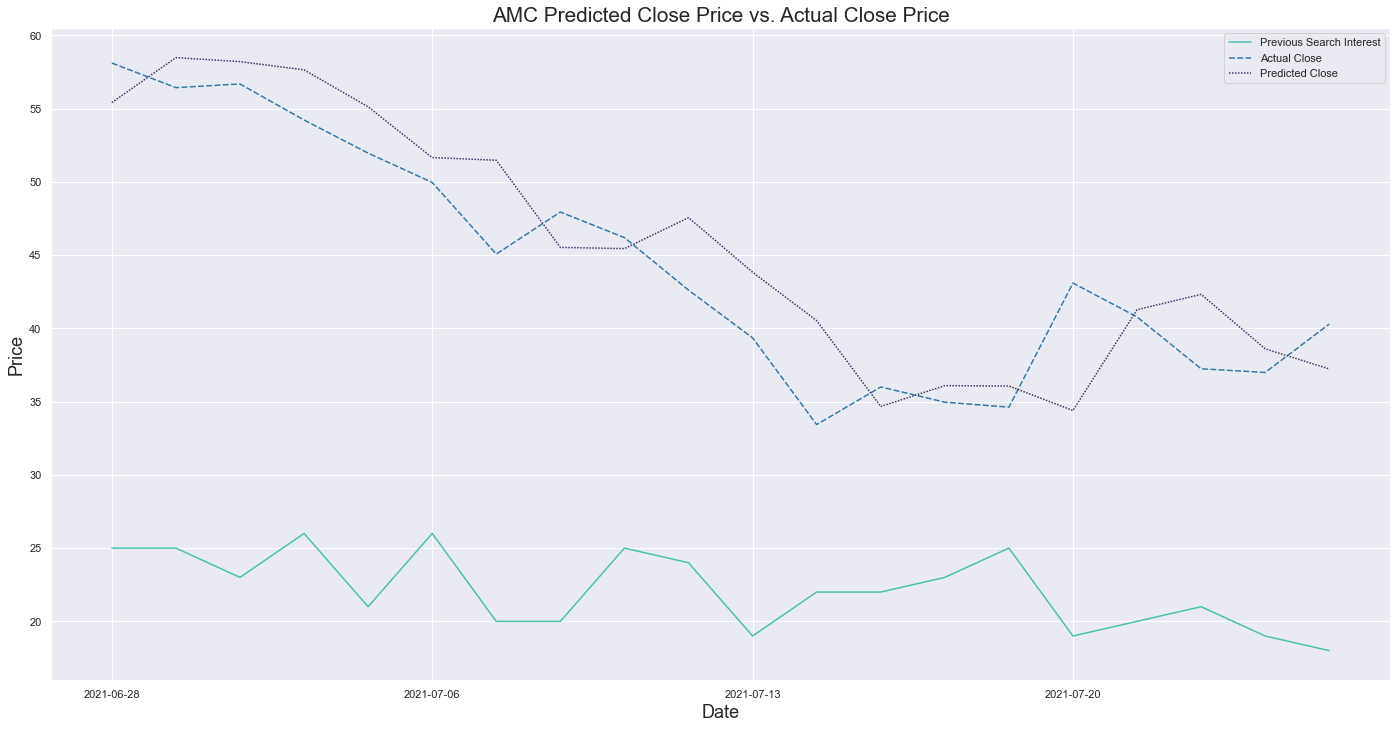

In [24]:
sns.set_theme(style = "darkgrid")
fig_AMC, ax = plt.subplots(figsize = (24,12))
sns.lineplot(data=lastMonthDf_AMC[["Previous Search Interest","Actual Close","Predicted Close"]],
                   ax = ax, palette = palette)


#add title and axis labels
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price", fontsize = 18)
plt.title("AMC Predicted Close Price vs. Actual Close Price",
          fontsize = 'xx-large')
ax.xaxis.set_major_locator(mp.ticker.MultipleLocator(5))

#add legend
plt.legend()

#display plot
plt.show() 

## Comparing Prediction Model by Stock

In [25]:
score_AMC = explained_variance_score(y_test_AMC, predictions_AMC)
forecastError_AMC = [y_test_AMC[i]-predictions_AMC[i] for i in range(len(y_test_AMC))]
bias_AMC = sum(forecastError_AMC) * 1.0 / len(y_test_AMC)
MAE_AMC = abs(mean(forecastError_AMC))
RMSE_AMC = math.sqrt(MAE_AMC)
R2_AMC = r2_score(y_test_AMC, predictions_AMC)

In [26]:
score_GME = explained_variance_score(y_test_GME, predictions_GME)
forecastError_GME = [y_test_GME[i]-predictions_GME[i] for i in range(len(y_test_GME))]
bias_GME = sum(forecastError_GME) * 1.0/len(y_test_GME)
MAE_GME = abs(mean(forecastError_GME))
RMSE_GME = math.sqrt(mean(forecastError_GME))
R2_GME = r2_score(y_test_GME, predictions_GME)

In [27]:
stockModelScoreComparison = np.matrix([[score_AMC, score_GME], [bias_AMC, bias_GME], [MAE_AMC, MAE_GME], [RMSE_AMC, RMSE_GME], [R2_AMC, R2_GME]])
stockModelScoreComparison= pd.DataFrame(stockModelScoreComparison)
stockModelScoreComparison.columns = [ 'AMC', 'GME']
stockModelScoreComparison.index = ['Score','Bias','Mean Absolute Error','Root Mean Squared Error','R-Squared']
stockModelScoreComparison

,AMC,GME
Score,0.782383,0.753718
Bias,-1.279159,5.429247
Mean Absolute Error,1.279159,5.429247
Root Mean Squared Error,1.130999,2.330074
R-Squared,0.755696,0.611181


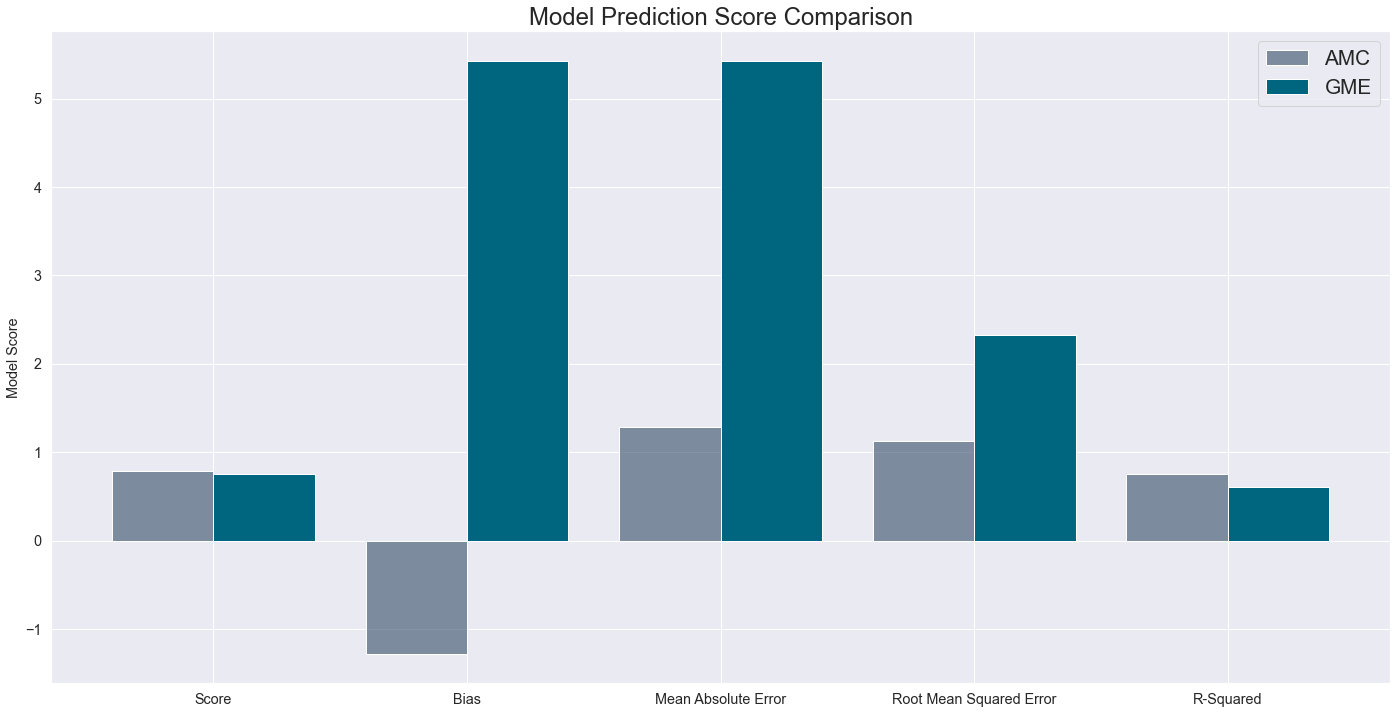

In [28]:
X = stockModelScoreComparison.index
AMC = stockModelScoreComparison.AMC
GME = stockModelScoreComparison.GME
  
X_axis = np.arange(len(X))
plt.subplots(figsize = (24,12))

plt.bar(X_axis - 0.2, AMC, 0.4, label = 'AMC',color=(0.2, 0.3, 0.4, 0.6))
plt.bar(X_axis + 0.2, GME, 0.4, label = 'GME',color=(0,0.4,0.5))

plt.xticks(X_axis, X, fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.ylabel("Model Score", fontsize = 'large')
plt.title("Model Prediction Score Comparison", fontsize = 24)
    
plt.legend(fontsize = 'xx-large')
plt.show()

## Conclusion

The two stocks used in this analysis include Game Stop and AMC.
The historic Game Stop data represents a stock with an overall
lower average value for Google trends search history score while
conversely, AMC indicates a higher average for Google trends search
history score. Historical closing prices were analyzed against the
previous days share price, volume traded, and Google trends search
history score using linear regression model.  The analysis was used
to make predictions about the closing prices for both stocks during
the last two months of the second quarter and compare these predictions
against the actual stock prices for the same date range by overlaying
both trends in the graphs displayed in this report.


Visually, both stock prices overlay reasonably well with the predicted
versus actual stock prices and provide an encouraging view that our
factors model the change in the closing stock price over the last two
months.   Game Stop performs better overall with a score of .79, a R
squared value of .72, root mean square error of 8.05, and mean absolute
error of 5.91.  This effectively means 72% of the variation in the closing
stock price over the time range can be explained by the factors that were
tested.  In general, small values for the MSE and MAE are desirable as
this is a measure of the difference between actual values and the predicted
model.  The average close price over the year for Game Stop \$93.08 making
these values less than 10\% of the average close price. AMC performs lower
with a score of .52, a R squared value of .43, root mean square error of
25.80, and mean absolute error of 19.23.  With only 43\% variation in the
close price that can be explained by the tested factors, and average close
price of AMC for the year being \\$12.70 compared to the root mean square
error of two times the average price, AMC did not track against the prediction
model as well as Game Stop.   Overall, the use of a Google trends search
history score combined with previous price history and volume traded looks
to be an encouraging indicator of potential stock purchases.

